In [119]:
%load_ext autoreload
%autoreload 2
import os
import sys
print(os.getcwd())
os.chdir("../../Scene_Graph_Novelty/eda")
from embedding_scene_terms import save_json, read_json
os.chdir(sys.path[0])
print(os.getcwd())

from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from inference_det_with_probs import *
import mmcv
import pickle as pkl
from tqdm import tqdm
from PIL import Image, ImageDraw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/showalte/research/mmdetection/demo
/home/showalte/research/mmdetection/demo


In [2]:
config_file = '../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '../models/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [3]:
imgs = read_json("../../Scene_Graph_Novelty/data/coco/clean/images_train_coco_2017.json")

In [4]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [5]:
# model

In [180]:
# # test a single image
# lst = [123,2343,22345]
# paths = []

# for k in list(imgs.keys())[:3]:
#     img_path = "../../Scene_Graph_Novelty/data/coco/images/train2017/{}"\
#     .format(imgs[k]['file_name'])
#     paths.append(img_path)
#     # paths.append(imgs[k]['file_name'])
    
    
# # print(img_path)
# det_bboxes, det_labels, det_probs = inference_detector_with_probs(model, paths[0],score_thresh = 0.8)
# result = inference_detector(model, paths[0])
# # # res =  inference_detector_with_probs(model, img_path,score_thresh = 0.8)

# # to cpu()
# det_bboxes = det_bboxes[0].cpu().numpy()
# det_labels = det_labels[0].cpu().numpy()
# det_probs = det_probs[0].cpu().numpy()

# print(len(paths))
# with open("image_filename_ordering.pkl", 'wb') as file:
#     pkl.dump(paths,file)

with open("image_filename_ordering.pkl", 'rb') as file:
    paths = pkl.load(file)
    
print(len(paths))

bboxes = []
labels = []
probs = []
for p in tqdm(paths[:10]):
    img_path = "../../Scene_Graph_Novelty/data/coco/images/train2017/{}"\
    .format(p)
    det_bboxes, det_labels, det_probs = inference_detector_with_probs(model, img_path,score_thresh = 0.00)
    det_bboxes = det_bboxes[0].cpu().numpy()
    det_labels = det_labels[0].cpu().numpy()
    det_probs = det_probs[0].cpu().numpy()
    det_probs_background = 1 - det_probs.sum(axis = 1)
    # print(det_probs.shape)
    # print(np.expand_dims(det_probs_background, axis = 0).shape)
    det_probs = np.append(det_probs, 
                          np.expand_dims(det_probs_background, axis = 0).T,
                         axis = 1)
    # print(det_probs.sum(axis = 1))
    # print(det_bboxes.shape)
    assert det_bboxes.shape == (50,5), "ERROR"
    assert det_labels.shape[0] == 50, "ERROR"
    assert det_probs.shape == (50,81), "ERROR"
    bboxes.append(det_bboxes)
    labels.append(det_labels)
    probs.append(det_probs)

bboxes = np.stack(bboxes)
labels = np.stack(labels)
probs = np.stack(probs)
torch.save(bboxes, 'ms_coco_train2017_bboxes_t50.pt')
torch.save(labels, 'ms_coco_train2017_labels_t50.pt')
torch.save(probs, 'ms_coco_train2017_probs_t50.pt')
    


118287


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.23it/s]


In [183]:
a = torch.load('ms_coco_train2017_probs_t50.pt')
a.shape

(113, 50, 81)

In [95]:
print(det_probs.shape)

(50, 80)


In [80]:
np.set_printoptions(precision = 4,suppress =True)
det_probs.max(axis = 1)*100

array([99.6806, 99.4079, 98.2342, 94.4595, 90.2663, 79.9696, 72.9731,
       67.8126, 65.7061, 53.9823, 36.1723, 34.9419, 31.7786, 27.9886,
       26.8863, 24.9744, 24.0975, 22.2775, 17.5756, 16.0673, 15.1279,
       14.7865, 14.6985, 14.1507, 13.2822, 13.183 , 10.4523,  8.8929,
        8.4413,  7.0887,  6.3737,  5.8712,  5.866 ,  5.7242,  5.4982,
        5.2194,  5.0381,  4.3218,  4.1906,  4.1043,  3.8923,  3.5147,
        2.8384,  2.4975,  2.466 ,  2.4001,  2.3115,  2.28  ,  2.1795,
        2.0528,  2.0051,  1.9078,  1.8292,  1.8036,  1.793 ,  1.558 ,
        1.4734,  1.4317,  1.3834,  1.2286,  1.1784,  1.164 ,  1.1588,
        1.1281,  1.1053,  1.1032,  1.0994,  1.0992,  1.0613,  1.0111],
      dtype=float32)

In [129]:
det_bboxes
# det_probs.max(axis =1)

array([[345.0498,  17.0103, 481.5612, 299.2972,   0.9945],
       [349.8235, 124.9845, 484.9905, 344.7026,   0.9792],
       [472.4407, 173.9337, 510.9128, 220.1995,   0.9326]], dtype=float32)

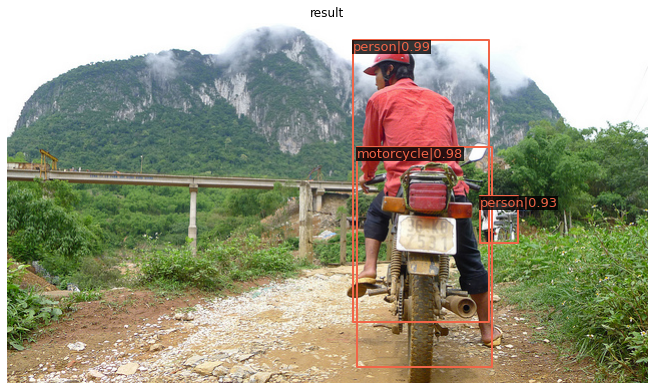

In [124]:
# show the results
show_result_pyplot(model, paths[0],result )

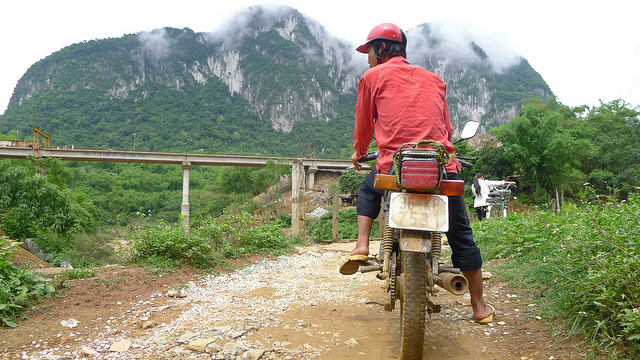

In [116]:
data = Image.open(paths[0])
data

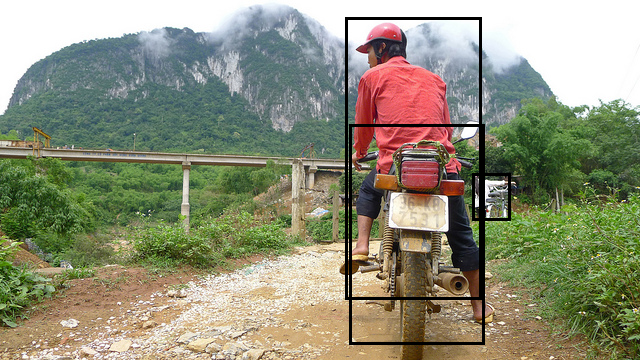

In [126]:
from copy import deepcopy
d = deepcopy(data)
data1 = ImageDraw.Draw(d)
boxes = det_bboxes
for i in range (boxes.shape[0]):
    box = boxes[i]
    # box[2] = box[0] + box[2]
    # box[3] = box[1] + box[3]
    # rectangle(box, fill=fill, outline=outline, width=width)
    data1.rectangle(box, outline = "black", width = 3)
d